In [1]:
# 设置工作路径
import os
os.chdir("C:\\Users\\15068\\Python\\在线网络计算器\\UKBBMASLD")

# 获取并打印当前工作路径
current_path = os.getcwd()
print("当前工作路径:", current_path)

当前工作路径: C:\Users\15068\Python\在线网络计算器\UKBBMASLD


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
df = pd.read_csv('MASLD_UKBB.csv')
# 划分特征和目标变量
X = df.drop(['group'], axis=1)
y = df['group']
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,                                                     
                                                    random_state=42, stratify=df['group'])
df.head()

,Age,Sex,Strength,Sleep,Light,Moderate,group
0,50,0,20,0.45057,0.15659,0.01078,0
1,43,1,46,0.34697,0.30435,0.02856,0
2,45,0,28,0.29867,0.20429,0.03220,0
3,56,1,50,0.36825,0.25433,0.02302,0
4,65,0,22,0.36124,0.23103,0.01621,0


In [3]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# XGBoost模型参数
params_xgb = {    
    'learning_rate': 0.02,            # 学习率，控制每一步的步长，用于防止过拟合。典型值范围：0.01 - 0.1    
    'booster': 'gbtree',              # 提升方法，这里使用梯度提升树（Gradient Boosting Tree）    
    'objective': 'binary:logistic',   # 损失函数，这里使用逻辑回归，用于二分类任务    
    'max_leaves': 127,                # 每棵树的叶子节点数量，控制模型复杂度。较大值可以提高模型复杂度但可能导致过拟合    
    'verbosity': 1,                   # 控制 XGBoost 输出信息的详细程度，0表示无输出，1表示输出进度信息    
    'seed': 42,                       # 随机种子，用于重现模型的结果    
    'nthread': -1,                    # 并行运算的线程数量，-1表示使用所有可用的CPU核心    
    'colsample_bytree': 0.6,          # 每棵树随机选择的特征比例，用于增加模型的泛化能力    
    'subsample': 0.7,                 # 每次迭代时随机选择的样本比例，用于增加模型的泛化能力    
    'eval_metric': 'logloss'          # 评价指标，这里使用对数损失（logloss）
}

# 初始化XGBoost分类模型
model_xgb = xgb.XGBClassifier(**params_xgb)

# 定义参数网格，用于网格搜索
param_grid = {    
    'n_estimators': [100, 200, 300, 400, 500],  # 树的数量    
    'max_depth': [3, 4, 5, 6, 7],               # 树的深度    
    'learning_rate': [0.01, 0.02, 0.05, 0.1],   # 学习率
}

# 使用GridSearchCV进行网格搜索和k折交叉验证
grid_search = GridSearchCV(    
    estimator=model_xgb,    
    param_grid=param_grid,    
    scoring='neg_log_loss',  # 评价指标为负对数损失    
    cv=5,                    # 5折交叉验证    
    n_jobs=4,               # 并行计算    
    verbose=1                # 输出详细进度信息
)

# 训练模型
grid_search.fit(X_train, y_train)

# 输出最优参数
print("Best parameters found: ", grid_search.best_params_)
print("Best Log Loss score: ", -grid_search.best_score_)

# 使用最优参数训练模型
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 500}
Best Log Loss score:  0.6279602666008329


In [4]:
from sklearn.metrics import classification_report
# 预测测试集
y_pred = best_model.predict(X_test)
# 输出模型报告， 查看评价指标
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.69      0.68     11661
           1       0.63      0.60      0.61     10080

    accuracy                           0.65     21741
   macro avg       0.65      0.65      0.65     21741
weighted avg       0.65      0.65      0.65     21741



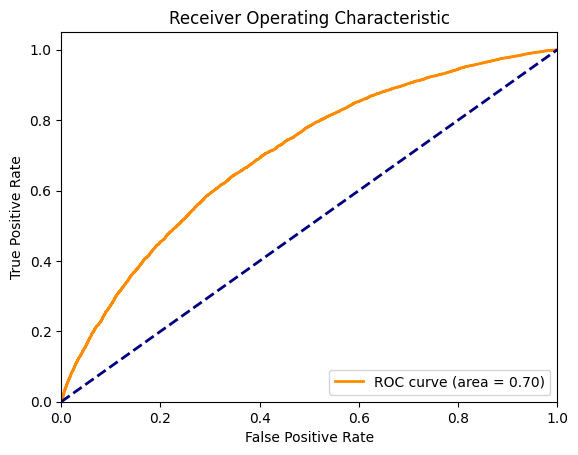

In [5]:
from sklearn.metrics import roc_curve, auc
# 预测概率
y_score = best_model.predict_proba(X_test)[:, 1]
# 计算ROC曲线
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_score)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)
# 绘制ROC曲线
plt.figure()
plt.plot(fpr_logistic, tpr_logistic, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_logistic)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [7]:
import joblib
# 保存模型
joblib.dump(best_model , 'XGBoost.pkl')

['XGBoost.pkl']

In [8]:
import streamlit as st
import joblib
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# Load the model
model = joblib.load('XGBoost.pkl')

# Define feature names
feature_names = [    
    "Age", "Sex", "Strength", "Sleep", "Light", "Moderate"]

# Streamlit user interface
st.title("Metabolic dysfunction-associated steatotic liver disease risk prediction calculator")

# age: numerical input
Age = st.number_input("Age:", min_value=40, max_value=70, value=60) 

# Sex: categorical selection
Sex = st.selectbox("Sex (0=Female, 1=Male):", options=[0, 1], format_func=lambda x: 'Female (0)' if x == 0 else 'Male (1)')

Strength = st.number_input("Hand grip strength (Max):", min_value=0, max_value=90, value=70) 

Sleep = st.number_input("Average sleep duration:", min_value=0.0, max_value=1.0, value=0.450)

Light = st.number_input("Average light duration:", min_value=0.0, max_value=1.0, value=0.250)

Moderate = st.number_input("Average moderate-vigorous duration:", min_value=0.0, max_value=1.0, value=0.055)

# Process inputs and make predictions
feature_values = [Age, Sex, Strength, Sleep, Light, Moderate]
features = np.array([feature_values])

if st.button("Predict"):    
    # Predict class and probabilities    
    predicted_class = model.predict(features)[0]    
    predicted_proba = model.predict_proba(features)[0]
    
    # Display prediction results    
    st.write(f"**Predicted Class:** {predicted_class}")    
    st.write(f"**Prediction Probabilities:** {predicted_proba}")
    
    # Generate advice based on prediction results    
    probability = predicted_proba[predicted_class] * 100
    
    if predicted_class == 1:        
         advice = (            
           f"Our model indicates that you have a high risk of MASLD. "
           f"The predicted probability of developing MASLD is {probability:.1f}%. "
           "While this is an estimate, it suggests that you may be at considerable risk. "
           "I recommend consulting a hepatologist or a liver specialist as soon as possible for further evaluation, "
           "to confirm the diagnosis and discuss appropriate management or treatment options."       
           )
    else:        
         advice = (            
           f"Our model indicates that you have a low risk of MASLD. "
           f"The predicted probability of not having MASLD is {probability:.1f}%. "
           "However, it is still important to maintain a healthy lifestyle to support liver health. "
           "Regular monitoring and periodic check-ups are recommended, especially if you have risk factors such as obesity, diabetes, or a history of liver disease."
           )
    st.write(advice)

    # Calculate SHAP values and display force plot    
    explainer = shap.TreeExplainer(model)    
    shap_values = explainer.shap_values(pd.DataFrame([feature_values], columns=feature_names))

    shap.force_plot(explainer.expected_value, shap_values[0], pd.DataFrame([feature_values], columns=feature_names), matplotlib=True)    
    plt.savefig("shap_force_plot.png", bbox_inches='tight', dpi=1200) 

    st.image("shap_force_plot.png")

2025-07-17 22:29:01.650 
  command:

    streamlit run C:\Users\15068\anaconda3\envs\base_clean\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
